In [1]:
import matplotlib.pyplot as plt
import numpy as np
import deepmars
import os
import h5py
import pandas as pd

In [2]:
from deepmars.models import predict_model as pm

Using TensorFlow backend.


In [3]:
model = pm.load_model("../models/model_keras2.h5")

/Users/lee/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
processed_data = os.path.join("../tests/")
gen_imgs = h5py.File(os.path.join(processed_data, 'ran_images_175000.hdf5'), 'r')
#gen_craters = h5py.File(os.path.join(processed_data, 'train_craters.hdf5'), 'r')
gen_craters = pd.HDFStore(processed_data + '/ran_craters_175000.hdf5', 'r')


In [5]:
def plot_loc(loc, index, imgs, craters,fmt="05d"):
    name='img_{}'.format(format(index,fmt))
    fig = plt.figure(figsize=[20, 20])
    [ax1, ax2, ax3] = fig.subplots(1,3)
    ax1.imshow(imgs['input_images'][loc][...], origin='upper', cmap='Greys_r')#, vmin=120, vmax=200)
    ax2.imshow(imgs['target_masks'][loc][...], origin='upper', cmap='Greys_r')
    im = np.dstack([imgs['input_images'][loc][...],imgs['input_images'][loc][...],imgs['input_images'][loc][...]])
    im[...,0][imgs['target_masks'][loc][...]>0.9]=0.
    im[...,1][imgs['target_masks'][loc][...]>0.9]=0.
    im[...,2][imgs['target_masks'][loc][...]>0.9]=255.
    ax3.imshow(im, origin='upper')
    plt.show()
    print("Long Lat Bounds")
    print("\t{}".format(imgs['longlat_bounds'].attrs['definition']))
    print("\t{}".format(imgs['longlat_bounds']['img_{}'.format(format(index,fmt))][...]))
    print("\t{}".format(imgs['pix_bounds'].attrs['definition']))
    print("\t{}".format(imgs['pix_bounds'][name][...]))
    
    print("\tFound {} craters".format(craters[name].size))
    return imgs['pix_bounds'][name][...]

def predict(loc, index, imgs, craters, fmt="05d"):
    # Use the CNN to make a prediction
    pred = model.predict(np.array(imgs['input_images'][loc:loc+1][..., np.newaxis]))
    # Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
    extracted_rings = deepmars.features.template_match_target.template_match_t(pred[0].copy(), minrad=3.)
    
    fig = plt.figure(figsize=[16, 16])
    [[ax1, ax2], [ax3, ax4]] = fig.subplots(2,2)
    ax1.imshow(imgs['input_images'][loc][...], origin='upper', cmap='Greys_r', vmin=50, vmax=200)
    ax2.imshow(imgs['target_masks'][loc][...], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
    ax3.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
    ax4.imshow(imgs['input_images'][loc][...], origin='upper', cmap="Greys_r")
    for x, y, r in extracted_rings:
        circle = plt.Circle((x, y), r, color='red', fill=False, linewidth=2, alpha=0.5)
        ax4.add_artist(circle)
    ax1.set_title('Moon DEM Image')
    ax2.set_title('Ground-Truth Target Mask')
    ax3.set_title('CNN Predictions')
    ax4.set_title('Post-CNN Craters')
    plt.show()

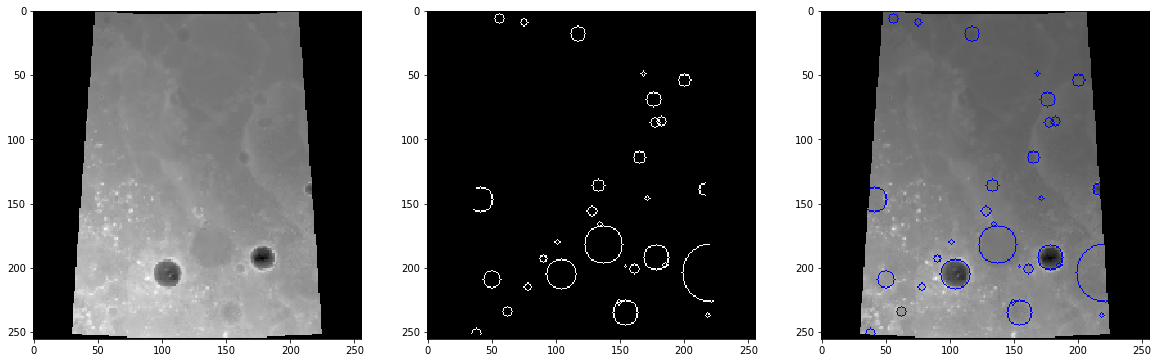

Long Lat Bounds
	(long min, long max, lat min, lat max) of the cropped image.
	[58.23082835 69.94920052 39.69164152 51.41001368]
	Pixel bounds of the Global DEM region that was cropped for the image.
	[70605 11437 74078 14910]
	Found 186 craters


In [6]:
loc = 8
index=175000+loc
ll = plot_loc(loc,index,gen_imgs,gen_craters)

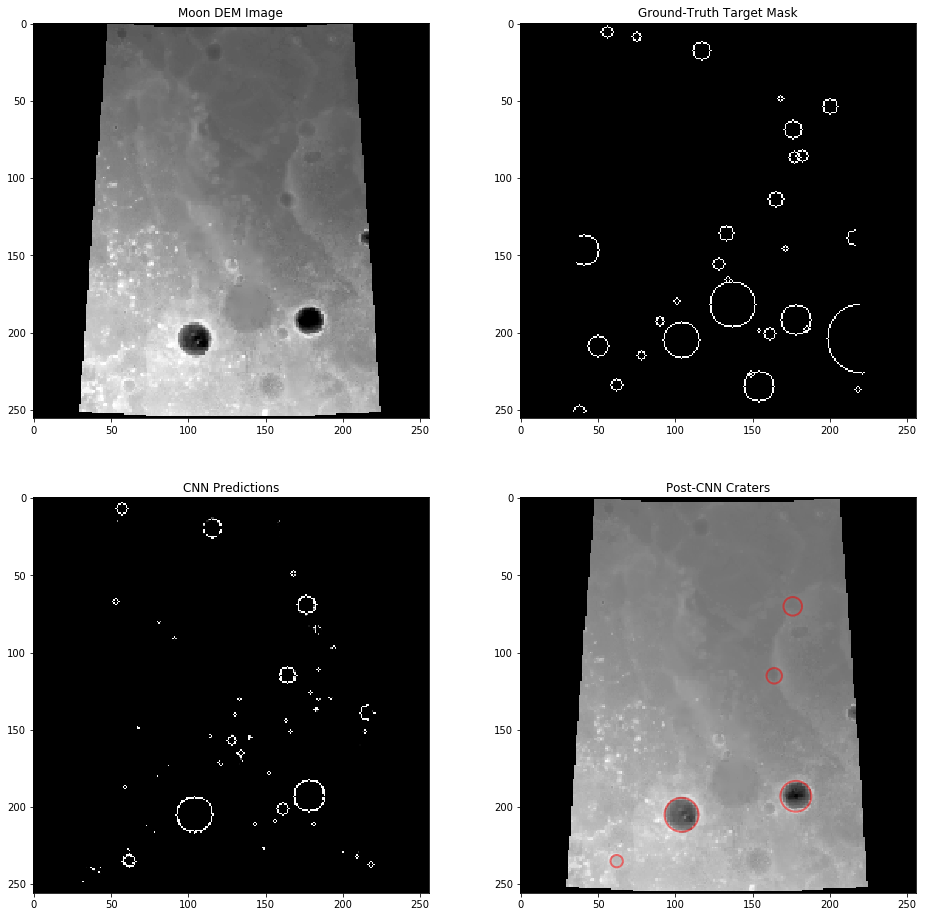

In [7]:
predict(loc, index,gen_imgs, gen_craters)